# Debugging XGBoost Training Jobs with Amazon SageMaker Debugger Using Rules

This notebook was created and tested on an ml.m5.4xlarge notebook instance.

## Overview

Amazon SageMaker Debugger is a new capability of Amazon SageMaker that allows debugging machine learning training. 
Amazon SageMaker Debugger helps you to monitor your training in near real time using rules and would provide you alerts, once it has detected inconsistency in training. 

Using Amazon SageMaker Debugger is a two step process: Saving tensors and Analysis.
Let's look at each one of them closely.

### Saving tensors

In deep learning algorithms, tensors define the state of the training job at any particular instant in its lifecycle.
Amazon SageMaker Debugger exposes a library which allows you to capture these tensors and save them for analysis.
Although XGBoost is not a deep learning algorithm, Amazon SageMaker Debugger is highly customizable and can help provide interpretability by saving insightful metrics, such as performance metrics or feature importances, at different frequencies.
Refer to [documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/xgboost.md) for details on how to save the metrics you want.


### Analysis

After the tensors are saved, perform automatic analysis by running debugging ***Rules***.
On a very broad level, a rule is Python code used to detect certain conditions during training.
Some of the conditions that a data scientist training an algorithm may care about are monitoring for gradients getting too large or too small, detecting overfitting, and so on.
Amazon SageMaker Debugger comes pre-packaged with certain rules that can be invoked on Amazon SageMaker. Users can also write their own rules using the Amazon SageMaker Debugger APIs. 
For more information about automatic analysis using a rule, see the [rules documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md).

In [1]:
! python -m pip install smdebug

In [2]:

import boto3
import sagemaker

Amazon SageMaker Debugger is available in Amazon SageMaker XGBoost container version 0.90-2 or later. If you want to use XGBoost with Amazon SageMaker Debugger, you have to specify `repo_version='0.90-2'` in the `get_image_uri` function.

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

# Below changes the Region to be one where this notebook is running
region = boto3.Session().region_name

container = get_image_uri(region, "xgboost", repo_version="1.2-1")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [4]:
container

'246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.2-1'

## Training XGBoost models in Amazon SageMaker with Amazon SageMaker Debugger

Now train an XGBoost model with Amazon SageMaker Debugger enabled and monitor the training jobs. This is done using the Amazon SageMaker Estimator API. While the training job is running, use Amazon SageMaker Debugger API to access saved tensors in real time and visualize them. You can rely on Amazon SageMaker Debugger to take care of downloading a fresh set of tensors every time you query for them.

This example is adapted from [XGBoost for Regression](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/xgboost_abalone). Refer to [XGBoost for Regression](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/xgboost_abalone) for an example of using classification from Amazon SageMaker's implementation of [XGBoost](https://github.com/dmlc/xgboost).

### Download data
Data Source: [https://archive.ics.uci.edu/ml/machine-learning-databases/adult/](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/)

Let's __download__ the data and save it in the local folder with the name adult.data and adult.test from UCI repository$^{[2]}$.

$^{[2]}$Dua Dheeru, and Efi Karra Taniskidou. "[UCI Machine Learning Repository](http://archive.ics.uci.edu/ml)". Irvine, CA: University of California, School of Information and Computer Science (2017).

In [5]:
from data_utils import upload_to_s3

bucket = sagemaker.Session().default_bucket()
prefix = "DEMO-smdebug-xgboost-adult.data"

In [6]:
import os 
import urllib 
raw_train_file = "adult.data"
raw_validation_file = "adult.test"
adult_columns = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status",
                 "Occupation", "Relationship", "Ethnic group", "Sex", "Capital Gain", "Capital Loss",
                 "Hours per week", "Country", "Target"]
if not os.path.isfile(raw_train_file):
    urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                              raw_train_file)
    print('adult.data saved!')
else:
    print('adult.data already on disk.')

if not os.path.isfile(raw_validation_file):
    urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                              raw_validation_file)
    print('adult.test saved!')
else:
    print('adult.test already on disk.')    

adult.data already on disk.
adult.test already on disk.


### Loading the data: Adult Dataset
From the UCI repository of machine learning datasets, this database contains 14 features concerning demographic characteristics of 45,222 rows (32,561 for training and 12,661 for testing). The task is to predict whether a person has a yearly income that is more or less than $50,000.

Here are the features and their possible values:
1. **Age**: continuous.
1. **Workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
1. **Fnlwgt**: continuous (the number of people the census takers believe that observation represents).
1. **Education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
1. **Education-num**: continuous.
1. **Marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
1. **Occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
1. **Relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
1. **Ethnic group**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
1. **Sex**: Female, Male.
    * **Note**: this data is extracted from the 1994 Census and enforces a binary option on Sex
1. **Capital-gain**: continuous.
1. **Capital-loss**: continuous.
1. **Hours-per-week**: continuous.
1. **Native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Next we specify our binary prediction task:  
15. **Target**: <=50,000, >$50,000.

In [7]:
#one or more space 
import pandas as pd 
training_data = pd.read_csv(raw_train_file,
                             names=adult_columns,
                             sep=r'\s*,\s*',
                             engine='python',
                             na_values="?").dropna()

testing_data = pd.read_csv(raw_validation_file,
                            names=adult_columns,
                            sep=r'\s*,\s*',
                            engine='python',
                            na_values="?",
                            skiprows=1).dropna()

training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [148]:
from sklearn import preprocessing
import numpy as np 
train_file = "train_data.csv"
validation_file = "test_features.csv"

def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            #  print('Column:', column, result[column])
            result[column] = encoders[column].fit_transform(result[column].fillna('None'))
    return result, encoders

training_data = pd.concat([training_data['Target'], training_data.drop(['Target'], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv(train_file, index=False, header=False)

testing_data = pd.concat([testing_data['Target'], testing_data.drop(['Target'], axis=1)], axis=1)
test_features, _ = number_encode_features(testing_data)

# test_features = testing_data.drop(['Target'], axis = 1)
# test_target = testing_data['Target']
headers = test_features.columns
test_features.to_csv(validation_file, index=False, header=False)

In [9]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload(train_file, 's3://{}/{}'.format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type='csv')
test_uri = S3Uploader.upload(validation_file, 's3://{}/{}'.format(bucket, prefix))

In [118]:
from sagemaker import get_execution_role

role = get_execution_role()
base_job_name = "demo-smdebug-xgboost-classification"
bucket_path = 's3://{}/{}'.format(bucket, base_job_name)

hyperparameters={
    "max_depth": "6",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "objective": "binary:logistic",
#     binary:logistic
    "num_round": "200",
    "tree_method": "gpu_hist", 
#     "num_class": "2"
}

save_interval = 5

base_job_name = "demo-smdebug-xgboost-regression"

### Enabling Debugger in Estimator object


#### DebuggerHookConfig

Enabling Amazon SageMaker Debugger in training job can be accomplished by adding its configuration into Estimator object constructor:

```python
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

estimator = Estimator(
    ...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "10"
                }
            )
        ]
    )
)
```
Here, the `DebuggerHookConfig` object instructs `Estimator` what data we are interested in.
Two parameters are provided in the example:

- `s3_output_path`: it points to S3 bucket/path where we intend to store our debugging tensors.
  Amount of data saved depends on multiple factors, major ones are: training job / data set / model / frequency of saving tensors.
  This bucket should be in your AWS account, and you should have full access control over it.
  **Important Note**: this s3 bucket should be originally created in the same region where your training job will be running, otherwise you might run into problems with cross region access.

- `collection_configs`: it enumerates named collections of tensors we want to save.
  Collections are a convinient way to organize relevant tensors under same umbrella to make it easy to navigate them during analysis.
  In this particular example, you are instructing Amazon SageMaker Debugger that you are interested in a single collection named `metrics`.
  We also instructed Amazon SageMaker Debugger to save metrics every 10 iteration.
  See [Collection](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#collection) documentation for all parameters that are supported by Collections and DebuggerConfig documentation for more details about all parameters DebuggerConfig supports.
  
#### Rules

Enabling Rules in training job can be accomplished by adding the `rules` configuration into Estimator object constructor.

- `rules`: This new parameter will accept a list of rules you wish to evaluate against the tensors output by this training job.
  For rules, Amazon SageMaker Debugger supports two types:
  - SageMaker Rules: These are rules specially curated by the data science and engineering teams in Amazon SageMaker which you can opt to evaluate against your training job.
  - Custom Rules: You can optionally choose to write your own rule as a Python source file and have it evaluated against your training job.
    To provide Amazon SageMaker Debugger to evaluate this rule, you would have to provide the S3 location of the rule source and the evaluator image.

In this example, you will use a Amazon SageMaker's LossNotDecreasing rule, which helps you identify if you are running into a situation where the training loss is not going down.

```python
from sagemaker.debugger import rule_configs, Rule

estimator = Estimator(
    ...,
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ],
)
```

- `rule_parameters`: In this parameter, you provide the runtime values of the parameter in your constructor.
  You can still choose to pass in other values which may be necessary for your rule to be evaluated.
  In this example, you will use Amazon SageMaker's LossNotDecreasing rule to monitor the `metircs` collection.
  The rule will alert you if the tensors in `metrics` has not decreased for more than 10 steps.

In [119]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator

algorithm_mode_default_estimator = Estimator(
    role=role,
    base_job_name=base_job_name,
    train_instance_count=1,
#     train_instance_type='ml.m5.xlarge',
    train_instance_type='ml.p2.xlarge',
    image_uri=container,
    hyperparameters=hyperparameters,
    train_max_run=1800,

    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=bucket_path,  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
        ],
    ),

    rules=[
        Rule.sagemaker(rule_configs.create_xgboost_report()),

        Rule.sagemaker(
#             rule_configs.feature_importance_overweight(),
            rule_configs.loss_not_decreasing(),
            
#             rule_parameters={
#                 "collection_names": "metrics",
#                 "num_steps": str(save_interval * 2),
#             },
        ),
        Rule.sagemaker(
            base_config=rule_configs.overtraining(),
            rule_parameters={
                "patience_train": "3",
                "patience_validation": "5",
                "delta": "0.05"
            },
        )   

    ],
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


With the next step, start a training job by using the Estimator object you created above. This job is started in an asynchronous, non-blocking way. This means that control is passed back to the notebook and further commands can be run while the training job is progressing.

In [120]:
from sagemaker.session import s3_input

train_s3_input = s3_input(train_uri, content_type="csv")
validation_s3_input = s3_input(test_uri, content_type="csv")
algorithm_mode_default_estimator.fit(
    {"train": train_s3_input, "validation": validation_s3_input},
    # This is a fire and forget event. By setting wait=False, you just submit the job to run in the background.
    # Amazon SageMaker starts one training job and release control to next cells in the notebook.
    # Follow this notebook to see status of the training job.
    wait=False
)

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Result

As a result of the above command, Amazon SageMaker starts one training job and one rule job for you. The first one is the job that produces the tensors to be analyzed. The second one analyzes the tensors to check if `train-rmse` and `validation-rmse` are not decreasing at any point during training.

Check the status of the training job below.
After your training job is started, Amazon SageMaker starts a rule-execution job to run the LossNotDecreasing rule.

**Note that the next cell blocks until the rule execution job ends. You can stop it at any point to proceed to the rest of the notebook. Once it says Rule Evaluation Status is Started, and shows the `RuleEvaluationJobArn`, you can look at the status of the rule being monitored.**

In [121]:
import time

for _ in range(360):
    job_name = algorithm_mode_default_estimator.latest_training_job.name
    client = algorithm_mode_default_estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = algorithm_mode_default_estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print("Training job status: {}, Rule Evaluation Status: {}".format(training_job_status, rule_evaluation_status))

    if rule_evaluation_status in ["Stopped", "IssuesFound", "NoIssuesFound"]:
        break

    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

### Check the status of the Rule Evaluation Job

To get the rule evaluation job that Amazon SageMaker started for you, run the command below. The results show you the `RuleConfigurationName`, `RuleEvaluationJobArn`, `RuleEvaluationStatus`, `StatusDetails`, and `RuleEvaluationJobArn`.
If the tensors meets a rule evaluation condition, the rule execution job throws a client error with `RuleEvaluationConditionMet`.

The logs of the rule evaluation job are available in the Cloudwatch Logstream `/aws/sagemaker/ProcessingJobs` with `RuleEvaluationJobArn`.

You can see that once the rule execution job starts, it identifies the loss not decreasing situation in the training job, it raises the `RuleEvaluationConditionMet` exception, and it ends the job.

In [122]:
algorithm_mode_default_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'CreateXgboostReport',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:230755935769:processing-job/demo-smdebug-xgboost-regre-createxgboostreport-90d6c665',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2021, 3, 29, 3, 39, 55, 87000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:230755935769:processing-job/demo-smdebug-xgboost-regre-lossnotdecreasing-edeabb87',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule LossNotDecreasing at step 100 resulted in the condition being met\n',
  'LastModifiedTime': datetime.datetime(2021, 3, 29, 3, 39, 55, 87000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overtraining',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:230755935769:processing-job/demo-smdebug-xgboost-regre-overtraining-efd4dcbd',
  'RuleEvaluationStatus': 'NoIssuesFou

## Making this a good run

In previous example, you saw how a LossNotDecreasing rule was run that analyzed the tensors when training was running and produced an alert.

You can go back and change the hyperparameters passed to the estimator to `hyperparameters` and start a new training job (e.g., use a smaller learning rate `eta=0.05`). You can see that the LossNotDecreasing rule is not fired in that case as both `train-rmse` and `validation-rmse` keep decreasing steadily throughout the entire training duration.

## Data Analysis - Manual

Now that you've trained the system, analyze the data.
Here, you focus on after-the-fact analysis.

You import a basic analysis library, which defines the concept of trial, which represents a single training run.

In [123]:
from smdebug.trials import create_trial

s3_output_path = algorithm_mode_default_estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2021-03-29 03:41:04.746 ip-172-16-51-26:5544 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-230755935769/demo-smdebug-xgboost-classification/demo-smdebug-xgboost-regression-2021-03-29-03-25-01-457/debug-output


You can list all the tensors that you know something about. Each one of these names is the name of a tensor. The name is a combination of the feature name, which in these cases, is auto-assigned by XGBoost, and whether it's an evaluation metric, feature importance, or SHAP value.

In [124]:
trial.tensor_names()

['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f2',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f10',
 'feature_importance/cover/f11',
 'feature_importance/cover/f12',
 'feature_importance/cover/f13',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f10',
 'feature_importance/gain/f11',
 'feature_importance/gain/f12',
 'feature_importance/gain/f13',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_im

For each tensor, ask for the steps where you have data. In this case, every five steps

In [125]:
trial.tensor("train-error").steps()

[0,
 5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150,
 155,
 160,
 165,
 170,
 175,
 180,
 185,
 190,
 195,
 200,
 205,
 210,
 215,
 220,
 225,
 230,
 235,
 240,
 245,
 250,
 255,
 260,
 265,
 270,
 275,
 280,
 285,
 290,
 295,
 300,
 305,
 310,
 315,
 320,
 325,
 330,
 335,
 340,
 345,
 350,
 355,
 360,
 365,
 370,
 375,
 380,
 385,
 390,
 395,
 400,
 405,
 410,
 415,
 420,
 425,
 430,
 435,
 440,
 445,
 450,
 455,
 460,
 465,
 470,
 475,
 480,
 485,
 490,
 495,
 500,
 505,
 510,
 515,
 520,
 525,
 530,
 535,
 540,
 545,
 550,
 555,
 560,
 565,
 570,
 575,
 580,
 585,
 590,
 595,
 600,
 605,
 610,
 615,
 620,
 625,
 630,
 635,
 640,
 645,
 650,
 655,
 660,
 665,
 670,
 675,
 680,
 685,
 690,
 695,
 700,
 705,
 710,
 715,
 720,
 725,
 730,
 735,
 740,
 745,
 750,
 755,
 760,
 765,
 770,
 775,
 780,
 785,
 790,
 795]

You can obtain each tensor at each step as a NumPy array.

In [126]:
type(trial.tensor("validation-error").value(10))

numpy.ndarray

### Performance metrics

You can also create a simple function that visualizes the training and validation errors as the training progresses.
Each gradient should get smaller over time, as the system converges to a good solution.
Remember that this is an interactive analysis. You are showing these tensors to give an idea of the data.

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
import re


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

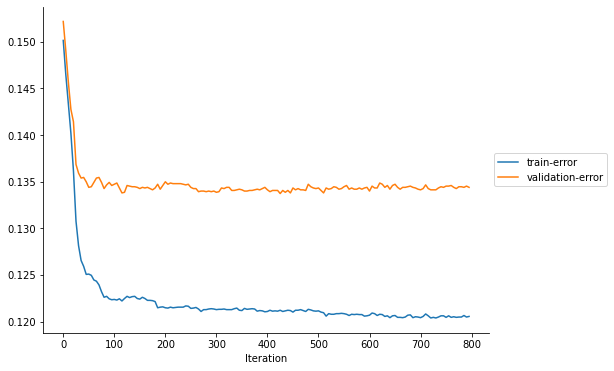

In [128]:
plot_collection(trial, "metrics")

### Feature importances

You can also visualize the feature priorities as determined by
[xgboost.get_score()](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score).
If you instructed Estimator to log the `feature_importance` collection, all five importance types supported by `xgboost.get_score()` will be available in the collection.

In [129]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

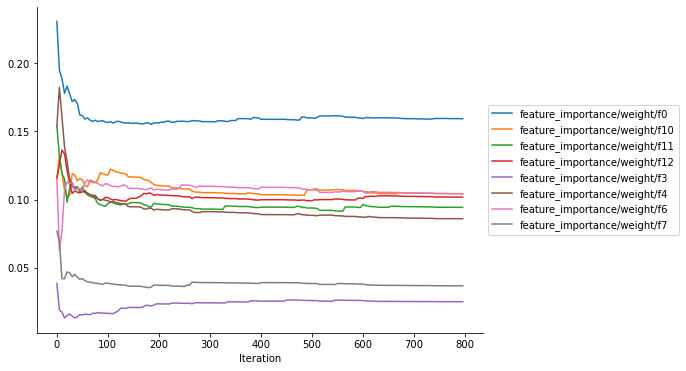

In [130]:
plot_feature_importance(trial)

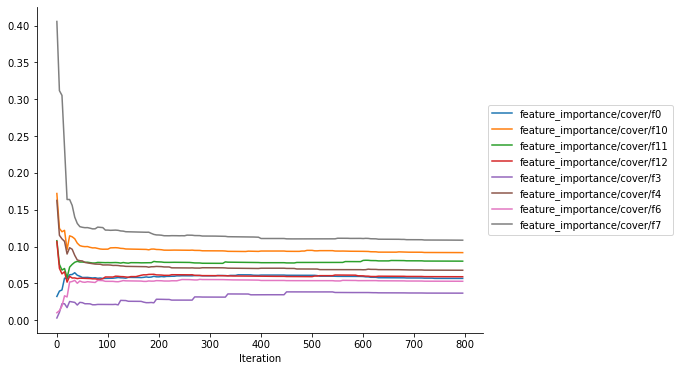

In [131]:
plot_feature_importance(trial, importance_type="cover")

### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is
another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output.
You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by [xgboost.predict(pred_contribs=True)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict)) will be available the `average_shap` collection.

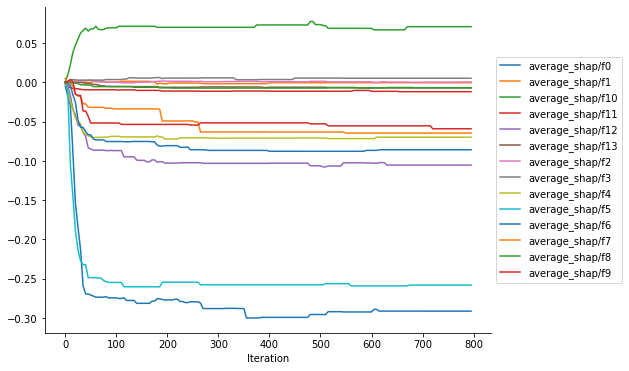

In [132]:
plot_collection(trial,"average_shap")

In [133]:
job_name = algorithm_mode_default_estimator.latest_training_job.name
!rm -rf rule-output
!aws s3 cp --recursive s3://{bucket}/{job_name}/rule-output/ rule-output

download: s3://sagemaker-us-west-2-230755935769/demo-smdebug-xgboost-regression-2021-03-29-03-25-01-457/rule-output/ProfilerReport-1616988301/profiler-output/profiler-reports/Dataloader.json to rule-output/ProfilerReport-1616988301/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-west-2-230755935769/demo-smdebug-xgboost-regression-2021-03-29-03-25-01-457/rule-output/ProfilerReport-1616988301/profiler-output/profiler-reports/BatchSize.json to rule-output/ProfilerReport-1616988301/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-west-2-230755935769/demo-smdebug-xgboost-regression-2021-03-29-03-25-01-457/rule-output/ProfilerReport-1616988301/profiler-output/profiler-reports/IOBottleneck.json to rule-output/ProfilerReport-1616988301/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-west-2-230755935769/demo-smdebug-xgboost-regression-2021-03-29-03-25-01-457/rule-output/ProfilerReport-1616988301/profiler-outp

In [137]:
from datetime import datetime
endpoint_name = f"DEMO-xgb-income-model-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("Endpoint name: ", endpoint_name)
endpoint_instance_count = 1
endpoint_instance_type = "ml.m5.large"
s3_key = f"s3://{bucket}/{prefix}"
s3_capture_upload_path = f'{s3_key}/datacapture'

Endpoint name:  DEMO-xgb-income-model-2021-03-29-0411


In [141]:
model_name = 'DEMO-clarify-model'
model = algorithm_mode_default_estimator.create_model(name=model_name)
container_def = model.prepare_container_def()


model = algorithm_mode_default_estimator.create_model(name=model_name)
container_def = model.prepare_container_def()

model.deploy(
    initial_instance_count=endpoint_instance_count,
    instance_type=endpoint_instance_type,
    endpoint_name=endpoint_name,
#     data_capture_config=data_capture_config,
)

Using already existing model: DEMO-clarify-model


---------------!

In [80]:
container_def

{'Image': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.2-1',
 'Environment': {},
 'ModelDataUrl': 's3://sagemaker-us-west-2-230755935769/demo-smdebug-xgboost-regression-2021-03-29-02-35-07-284/output/model.tar.gz'}

In [151]:
%store train_uri
%store test_uri
%store model_name
%store container_def 
%store train_file 
%store validation_file
%store headers
%store training_data
%store test_features

Stored 'train_uri' (str)
Stored 'test_uri' (str)
Stored 'model_name' (str)
Stored 'container_def' (dict)
Stored 'train_file' (str)
Stored 'validation_file' (str)
Stored 'headers' (Index)
Stored 'training_data' (DataFrame)
Stored 'test_features' (DataFrame)
